In [1]:
import sys

import polars as pl
import torch

from model_runner.model_train import TitanTrain
from models.Titans import TitanConfigWeekly, LMMModel
from utils.date_util import DateUtil

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = '../data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR

tb_bas_oper_part_mst = (pl.read_parquet(DIR + 'tb_bas_oper_part_mst.parquet')
                        .select(['OPER_PART_NO', 'OPER_PART_NM'])
                        .rename({'OPER_PART_NO': 'oper_part_no', 'OPER_PART_NM': 'oper_part_nm'}))
tb_dyn_fcst_demand = (pl.read_parquet(DIR + 'tb_dyn_fcst_dmnd.parquet')
                      .select(['PART_NO', 'DMND_QTY', 'DMND_DT', 'OPER_PART_NO'])
                      .rename({'PART_NO': 'part_no', 'OPER_PART_NO': 'oper_part_no', 'DMND_DT': 'demand_dt', 'DMND_QTY': 'demand_qty'})
                      .select(['part_no', 'oper_part_no', 'demand_dt', 'demand_qty']))
tb_dyn_fcst_demand_sellout = (pl.read_parquet(DIR + 'tb_dyn_fcst_dmnd_sellout.parquet')
                              .select(['PART_NO', 'DMND_QTY', 'DMND_DT', 'OPER_PART_NO'])
                              .rename({'PART_NO': 'part_no', 'OPER_PART_NO': 'oper_part_no', 'DMND_DT': 'demand_dt', 'DMND_QTY': 'demand_qty'})
                              .select(['part_no', 'oper_part_no', 'demand_dt', 'demand_qty']))

True
1
12.8
2.9.0.dev20250716+cu128
NVIDIA GeForce RTX 5080
2.9.0.dev20250716+cu128


In [2]:
dyn_demand_sellout = (tb_dyn_fcst_demand_sellout
                        .with_columns(pl.col('demand_dt')
                        .cast(pl.Int64)
                        .map_elements(DateUtil.yyyymmdd_to_date, return_dtype = pl.Date)))
dyn_demand = (dyn_demand_sellout
              .join(tb_bas_oper_part_mst, on = 'oper_part_no', how = 'left')
              .select(['oper_part_no', 'oper_part_nm', 'demand_dt', 'demand_qty'])
              .sort(['oper_part_no', 'demand_dt'])
              .with_columns([
                pl.col('demand_qty').cum_sum().over('oper_part_no').alias('cumsum_qty')
              ])
              .select(['oper_part_no', 'demand_dt', 'demand_qty', 'cumsum_qty'])
              .sort(['oper_part_no', 'demand_dt'])
              .with_columns(pl.col('demand_dt').map_elements(DateUtil.date_to_yyyyww, return_dtype = pl.Int64).alias('demand_dt'))
              .select('oper_part_no', 'demand_dt', 'demand_qty')
              .group_by(['oper_part_no', 'demand_dt'])
              .agg(pl.col('demand_qty').sum().alias('demand_qty'))
              .sort(['oper_part_no', 'demand_dt'])
              )

dyn_demand

oper_part_no,demand_dt,demand_qty
str,i64,f64
"""0001-1001""",201811,5.0
"""0001-1001""",201847,7.0
"""0001-1001""",202005,20.0
"""0001-1001""",202006,100.0
"""0001-1001""",202010,2.0
…,…,…
"""ZZ90239""",202043,1.0
"""ZZ90239""",202145,1.0
"""ZZ90239""",202325,1.0


In [3]:
from data_loader.TimeSeriesModule import MultiPartDataModule

config = TitanConfigWeekly()

data_module = MultiPartDataModule(
    df = dyn_demand,
    config = TitanConfigWeekly(),
    batch_size = 128,
    val_ratio = 0.2
)

train_loader = data_module.get_train_loader()
val_loader = data_module.get_val_loader()
inference_loader = data_module.get_inference_loader()

model = LMMModel(TitanConfigWeekly())

train_with_tta = TitanTrain().train_model_with_tta(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    epochs = 500
)

Epoch 1/500 | LR: 0.001000| Train Loss: 550526.8892 | Val Loss: 373452.6896
Epoch 2/500 | LR: 0.001000| Train Loss: 444023.9660 | Val Loss: 352668.6648
Epoch 3/500 | LR: 0.001000| Train Loss: 422312.0407 | Val Loss: 351398.2912
Epoch 4/500 | LR: 0.001000| Train Loss: 414651.3320 | Val Loss: 351859.2453
Epoch 5/500 | LR: 0.001000| Train Loss: 407794.2097 | Val Loss: 355818.2844
Epoch 6/500 | LR: 0.001000| Train Loss: 406012.2900 | Val Loss: 361337.0507
Epoch 7/500 | LR: 0.001000| Train Loss: 397405.5595 | Val Loss: 349157.5968
Epoch 8/500 | LR: 0.000999| Train Loss: 406074.5162 | Val Loss: 354674.6401
Epoch 9/500 | LR: 0.000999| Train Loss: 395653.0553 | Val Loss: 349889.9347
Epoch 10/500 | LR: 0.000999| Train Loss: 394588.5170 | Val Loss: 348954.7765
Epoch 11/500 | LR: 0.000999| Train Loss: 399878.3151 | Val Loss: 350542.3811
Epoch 12/500 | LR: 0.000999| Train Loss: 400088.6864 | Val Loss: 349401.6056
Epoch 13/500 | LR: 0.000998| Train Loss: 399430.2571 | Val Loss: 346778.8202
Epoch 14

In [4]:
torch.save(model.state_dict(), DIR + 'titan_tta_weekly_20250914_l54_h_27.pt')

In [5]:
from model_runner.model_inference import DMSForecaster
from models.Titans import TestTimeMemoryManager

ttm = TestTimeMemoryManager(model, lr = 1e-4)
dms = DMSForecaster(model, lmm_mode = 'eval', ttm = ttm)

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = next(model.parameters()).device

# 1) 배치 하나 꺼내기
x_val, y_val, parts = next(iter(val_loader))   # [B,L,1], [B,H], [B] (str list)
x_val = x_val.to(device).float()
y_val = y_val.to(device).float()

B, L, _ = x_val.shape
H = y_val.shape[1]

# (선택) TTM 컨텍스트 1회 주입
if hasattr(model, "encoder") and hasattr(model.encoder, "input_proj"):
    x_ctx = model.encoder.input_proj(x_val)        # [B,L,d_model]
    ttm.add_context(x_ctx)

# 2) DMS 예측 (메서드명이 forecast/forcast 섞일 수 있어 호환 처리)
if hasattr(dms, "forecast"):
    y_hat = dms.forecast(x_val, horizon=H)         # [B,H]
else:
    y_hat = dms.forcast(x_val, horizon=H)          # [B,H]

y_hat = y_hat.detach()

# 3) 간단 지표
mae = (y_hat - y_val).abs().mean(dim=1)            # [B]
mape = ((y_hat - y_val).abs() / (y_val.abs()+1e-6)).mean(dim=1)

print(f"[VAL] MAE mean={mae.mean().item():.4f} | MAPE mean={mape.mean().item()*100:.2f}%")


[VAL] MAE mean=61.3331 | MAPE mean=25416.13%


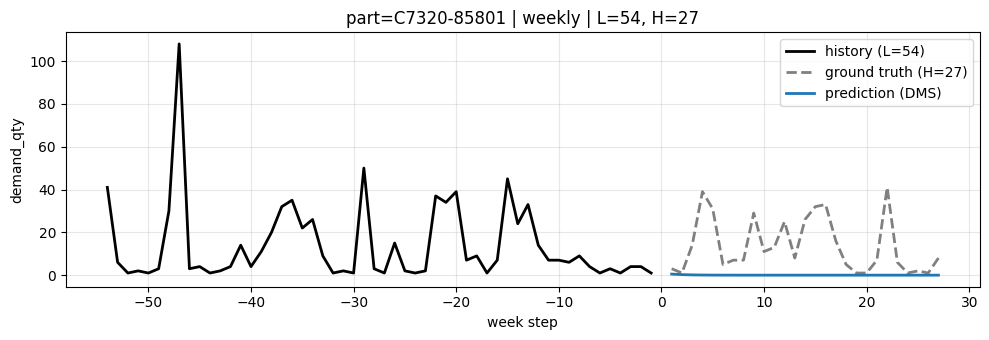

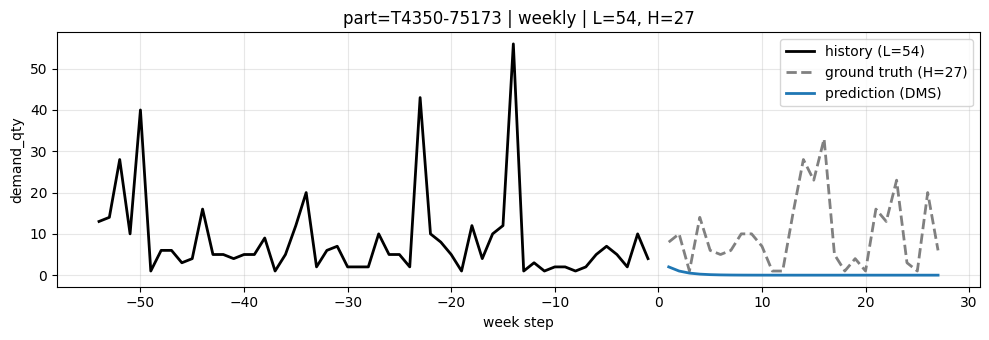

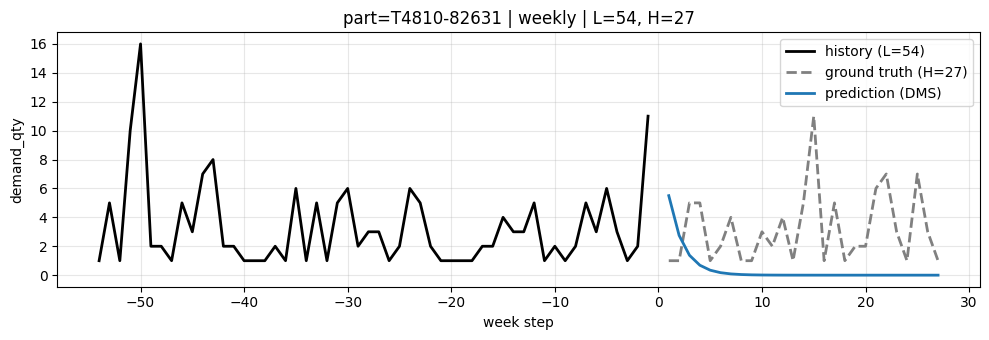

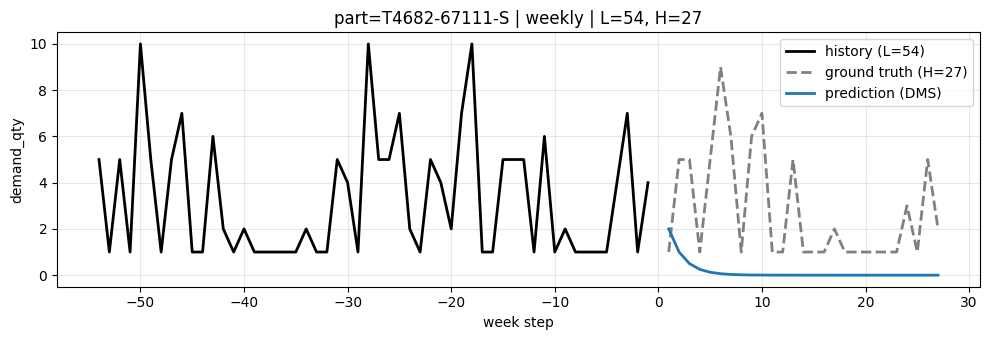

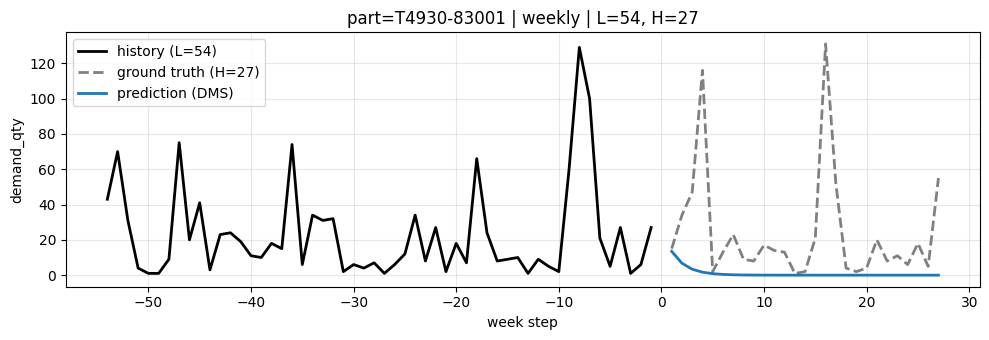

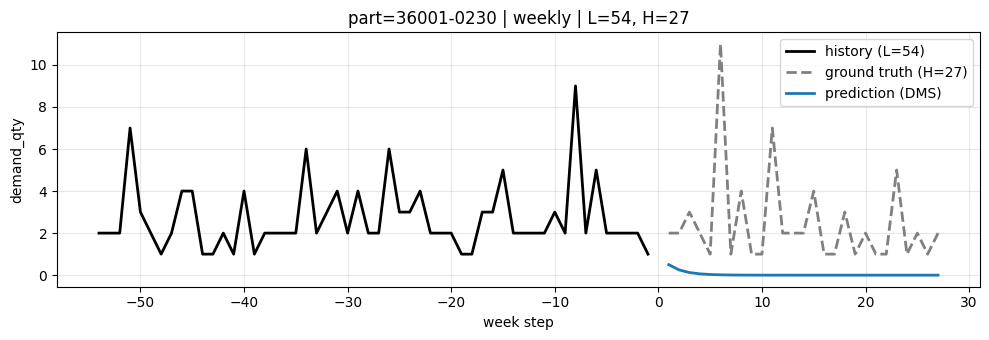

In [9]:
def plot_val_batch_weekly(x_val, y_val, y_hat, parts, lookback, k=6, same_ylim=False):
    """
    x축은 단순 step(주차) 인덱스:  -L..-1 | 1..H
    """
    x_val = x_val.detach().cpu().numpy()
    y_val = y_val.detach().cpu().numpy()
    y_hat = y_hat.detach().cpu().numpy()

    B, L, _ = x_val.shape
    H = y_val.shape[1]

    hist_idx = np.arange(-L, 0)        # 과거 L주
    fut_idx  = np.arange(1, H+1)       # 미래 H주

    # 공통 y-limits (선택)
    y_min, y_max = None, None
    if same_ylim:
        all_hist = x_val[:, :, 0].reshape(-1)
        all_gt   = y_val.reshape(-1)
        all_pred = y_hat.reshape(-1)
        lo = np.nanmin([all_hist.min(), all_gt.min(), all_pred.min()])
        hi = np.nanmax([all_hist.max(), all_gt.max(), all_pred.max()])
        pad = 0.05*(hi-lo+1e-6)
        y_min, y_max = lo - pad, hi + pad

    n = min(k, B)
    for i in range(n):
        hist = x_val[i, :, 0]
        gt   = y_val[i]
        pred = y_hat[i]
        part = parts[i] if isinstance(parts, (list, tuple)) else str(parts[i])

        plt.figure(figsize=(10, 3.5))
        plt.plot(hist_idx, hist, color='k', lw=2.0, label=f"history (L={lookback})")
        plt.plot(fut_idx, gt,   color='gray', lw=2.0, ls='--', label=f"ground truth (H={H})")
        plt.plot(fut_idx, pred, color='C0', lw=2.0, label="prediction (DMS)")

        plt.title(f"part={part} | weekly | L={lookback}, H={H}")
        plt.xlabel("week step")
        plt.ylabel("demand_qty")
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        if same_ylim:
            plt.ylim(y_min, y_max)
        plt.tight_layout()
        plt.show()

# 호출
plot_val_batch_weekly(x_val, y_val, y_hat, parts, lookback=L, k=6, same_ylim=False)